프로젝트 주제 : 건강 검진 결과를 토대로 흡연 여부 예측하기
======
제 4회 통계 최강자전 참가 프로젝트

팀 와글바글 : 박영원(대표), 서문세완, 홍수호

--------------

이 파일은 분석 코드 파일입니다.

약간의 설명이 함께 포함되어 있기는 하지만, 더 자세한 설명은 보고서 파일을 참조해주시면 감사하겠습니다.

데이터 분석 준비
---

In [1]:
#필수 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

#편의 세팅
os.chdir("C:/Users/pyw20/VScode_Workspace")
warnings.filterwarnings(action='ignore')
%matplotlib inline
plt.style.use('ggplot')

이번 프로젝트에 사용할 데이터는 2009년부터 2020년까지 국민건강보험공단에서 실시하는 기초건강검진 결과 데이터입니다.

사용할 핵심 라이브러리는 numpy, pandas, seaborn 그리고 sklearn입니다.

numpy와 pandas로 데이터의 전처리 및 재구성 작업을 진행하고, 

seaborn으로 시각화를, sklearn으로 모델링 작업을 진행했습니다.

먼저, pandas의 read_csv를 이용하여 데이터를 불러오겠습니다.

In [2]:
#데이터 불러오기
raw_data = pd.read_csv('Health Checkup Result.csv')
data = raw_data.copy()

간단하게 데이터셋에 대한 정보를 확인해보겠습니다.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     120000 non-null  int64  
 1   YEAR           120000 non-null  int64  
 2   IDV_ID         120000 non-null  int64  
 3   SEX            120000 non-null  int64  
 4   AGE_GROUP      120000 non-null  int64  
 5   AREA_CODE      120000 non-null  int64  
 6   HEIGHT         119991 non-null  float64
 7   WEIGHT         119991 non-null  float64
 8   WAIST          119988 non-null  float64
 9   SIGHT_LEFT     119979 non-null  float64
 10  SIGHT_RIGHT    119980 non-null  float64
 11  HEAR_LEFT      119984 non-null  float64
 12  HEAR_RIGHT     119983 non-null  float64
 13  BP_HIGH        119812 non-null  float64
 14  BP_LWST        119812 non-null  float64
 15  BLDS           119806 non-null  float64
 16  TOT_CHOLE      100579 non-null  float64
 17  TRIGLYCERIDE   100580 non-nul

마지막 4개 열의 경우 Dtype이 object인데, 모델링을 위해서는 int나 float의 숫자 형태로 바꿔주는 인코딩 작업을 해야합니다.
따라서, 데이터 타입이 object인 열은 전처리 과정에서 처리하도록 하겠습니다.

그 이외의 숫자 열에는 별도의 인코딩을 할 필요는 없는 것 같습니다.

그럼 지금부터는 데이터를 분석 목적에 맞도록 전처리하겠습니다.

먼저 예측하고자 하는 타깃 변수인 흡연 여부(SMK_STAT)가 결측값인 경우,
이는 학습에 이용할 수 없으므로 해당하는 행들은 잘라내도록 하겠습니다.

In [4]:
#타깃 변수가 결측값인 행 삭제
data.dropna(subset='SMK_STAT',inplace=True)
data.head(5)

,Unnamed: 0,YEAR,IDV_ID,SEX,AGE_GROUP,AREA_CODE,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,...,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT,DRK_YN,HCHK_CE_IN,CRS_YN,TTR_YN
0,285437,2009,297069,1,4,41,165.0,75.0,83.0,1.2,...,1.0,1.2,34.0,48.0,202.0,3.0,N,N,NaN,NaN
1,660095,2009,222353,1,7,41,175.0,70.0,88.0,1.2,...,1.0,0.8,24.0,24.0,34.0,3.0,Y,N,NaN,NaN
2,936773,2009,150310,1,11,46,160.0,55.0,77.0,0.8,...,1.0,0.8,22.0,18.0,12.0,2.0,N,Y,Y,Y
3,790463,2009,720146,2,9,26,140.0,45.0,72.0,0.8,...,1.0,0.9,21.0,15.0,20.0,1.0,N,N,NaN,NaN
4,691702,2009,535286,2,7,41,155.0,75.0,86.0,0.8,...,1.0,0.7,29.0,25.0,33.0,1.0,N,Y,NaN,Y


여기서 키(HEIGHT)와 몸무게(WEIGHT) 피처 값들의 일의 자리가 5 아니면 0으로 딱 떨어지는 것을 볼 수 있습니다.

이 데이터셋만 보고 누구인지 알아내는 것을 막기 위해 '비식별화'가 적용된 것 같습니다.

이로 인해 약간의 모델 성능 저하가 있을 수 있겠지만, 감안하고 계속 진행하도록 하겠습니다.

이번에는 전체 데이터셋에서 흡연 여부에 따른 분포가 어떻게 되는지 확인해보겠습니다.

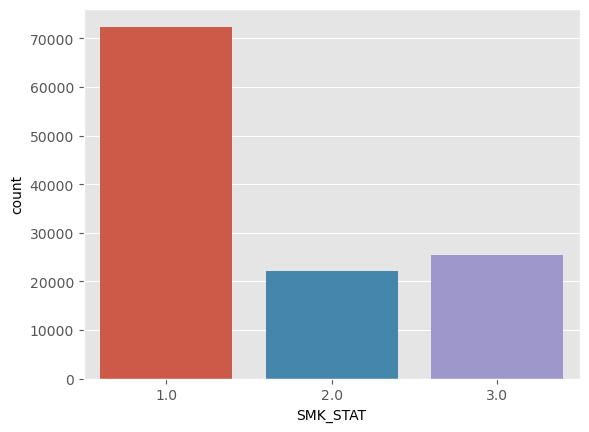

In [5]:
sns.countplot(data=data, x='SMK_STAT');

흡연 여부(SMK_STAT)는 비흡연자(1) / 금연자(2) / 흡연자(3) 이렇게 3가지 범주로 구분됩니다.

이때 흡연자와 비흡연자는 명확하게 구분되지만, 금연자의 경우 그 입지가 다소 애매합니다.

왜냐하면, 금연자들마다 각자 금연을 시도한 기간이 몇 주부터 시작해서, 몇 달, 몇 년까지 아주 다양할텐데,
이제 갓 금연을 시작한 사람과 금연을 시작한지 5년이 넘은 사람이 같은 범주로 묶이는 것은 적절하지 않다고 생각합니다.

더욱이 금연 기간에 대한 아무런 정보도 없을 수 없기 때문에, 이들을 흡연자 / 비흡연자 집단에 나누어 포함시키는 것도 불가능합니다.

따라서 금연자 데이터는 전부 삭제하도록 하겠습니다.
금연자 데이터를 제외하고도 남은 데이터 수가 여전히 10만에 가까우므로, 계속해서 분석을 이어나가도록 하겠습니다.

In [6]:
#금연자 데이터는 전부 삭제
data = data.query('SMK_STAT != 2')

#비흡연자는 0, 흡연자는 1에 매핑
data['SMK_STAT'] = data['SMK_STAT'].map({1:0, 3:1})

print(f'비흡연자(0) / 흡연자(1) 수 : \n{data["SMK_STAT"].value_counts()}')

비흡연자(0) / 흡연자(1) 수 : 
0    72371
1    25477
Name: SMK_STAT, dtype: int64


오직 신체 지표를 토대로만 흡연 여부를 예측하기 위한 모델이므로,
이와 관련 없는 '측정 연도', '지역 코드', '환자 ID' 등의 열은 제거하겠습니다.

In [7]:
#흡연 여부와 무관한 열(피처) 삭제
data.drop(['Unnamed: 0','IDV_ID','YEAR','AREA_CODE'],axis=1,inplace=True)
data.head(5)

,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,...,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT,DRK_YN,HCHK_CE_IN,CRS_YN,TTR_YN
0,1,4,165.0,75.0,83.0,1.2,1.5,1.0,1.0,118.0,...,1.0,1.2,34.0,48.0,202.0,1,N,N,NaN,NaN
1,1,7,175.0,70.0,88.0,1.2,1.0,1.0,1.0,144.0,...,1.0,0.8,24.0,24.0,34.0,1,Y,N,NaN,NaN
3,2,9,140.0,45.0,72.0,0.8,0.5,1.0,1.0,104.0,...,1.0,0.9,21.0,15.0,20.0,0,N,N,NaN,NaN
4,2,7,155.0,75.0,86.0,0.8,0.9,1.0,1.0,105.0,...,1.0,0.7,29.0,25.0,33.0,0,N,Y,NaN,Y
5,1,7,165.0,60.0,80.0,0.8,1.0,1.0,1.0,140.0,...,1.0,1.0,20.0,20.0,51.0,1,N,N,NaN,NaN


여기서 다시 한번 피처별 결측값 개수를 확인해보겠습니다.

In [8]:
#각 피처별 결측값 갯수 확인
data.isnull().sum()

SEX                  0
AGE_GROUP            0
HEIGHT               8
WEIGHT               8
WAIST               11
SIGHT_LEFT          17
SIGHT_RIGHT         17
HEAR_LEFT           13
HEAR_RIGHT          14
BP_HIGH            157
BP_LWST            157
BLDS               159
TOT_CHOLE        14566
TRIGLYCERIDE     14565
HDL_CHOLE        14566
LDL_CHOLE        15085
HMG                158
OLIG_PROTE_CD      619
CREATININE         158
SGOT_AST           158
SGPT_ALT           158
GAMMA_GTP          158
SMK_STAT             0
DRK_YN           14273
HCHK_CE_IN           0
CRS_YN           77307
TTR_YN           61926
dtype: int64

CRS_YN(치아 우식증 여부)과 TTR_YN(치석 여부)의 경우
구강 검진을 받지 않았다면 이 부분이 결측값으로 표시되었기 때문에,
결측값 수가 전체 데이터의 절반을 훌쩍 넘습니다.

그렇다면 유의미한 정보를 추출하는데 어려움이 있을 것으로 예상되어,
충치 여부(CRS_YN) TTR_YN(치석 여부) 열은 제거하겠습니다.

또한, 구강 검진 선택여부(HCHK_CE_IN)는 그 자체로 아무런 정보도 되지 않기 때문에 함께 제거하도록 하겠습니다.

In [9]:
#결측값이 전체 데이터의 절반을 넘는 열(피처) 삭제
data.drop(['HCHK_CE_IN','CRS_YN','TTR_YN'],axis=1,inplace=True)
data.head(5)

,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,...,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT,DRK_YN
0,1,4,165.0,75.0,83.0,1.2,1.5,1.0,1.0,118.0,...,45.0,59.0,15.6,1.0,1.2,34.0,48.0,202.0,1,N
1,1,7,175.0,70.0,88.0,1.2,1.0,1.0,1.0,144.0,...,55.0,98.0,15.5,1.0,0.8,24.0,24.0,34.0,1,Y
3,2,9,140.0,45.0,72.0,0.8,0.5,1.0,1.0,104.0,...,62.0,106.0,12.2,1.0,0.9,21.0,15.0,20.0,0,N
4,2,7,155.0,75.0,86.0,0.8,0.9,1.0,1.0,105.0,...,60.0,147.0,9.2,1.0,0.7,29.0,25.0,33.0,0,N
5,1,7,165.0,60.0,80.0,0.8,1.0,1.0,1.0,140.0,...,65.0,109.0,15.4,1.0,1.0,20.0,20.0,51.0,1,N


음주 여부(DRK_YN)의 경우, 이 피처를 그대로 사용하기에는 문제점이 있습니다.
왜냐하면 이 피처는 건강검진의 "결과"라기 보다는, 피검자의 문진표에 대한 "응답"이기 때문입니다.

In [10]:
#같은 의미이지만 표기가 다르기 때문에, 이를 통일
data['DRK_YN'] = data['DRK_YN'].map({'Y':1,'N':0,'1':1,'0':0,'1.0':1,'0.0':0})
print(f'음주 여부 피처의 결측값 수 : {data["DRK_YN"].isnull().sum()}')

음주 여부 피처의 결측값 수 : 14273


더욱이 이 피처를 결측값으로 가진 행들이 상당히 많습니다.
이 피처는 네(1)/아니오(0) 두 가지 범주만 가지고 있기 때문에, 
이 많은 행들을 어떤 하나의 값으로 대체할 경우 모델의 성능을 저하시킬 우려가 있습니다.

따라서 음주 여부(DRK_YN) 피처는 삭제하도록 하겠습니다.

In [11]:
#음주 여부 열 삭제
data.drop(['DRK_YN'],axis=1,inplace=True)
data.head(5)

,SEX,AGE_GROUP,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,...,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT
0,1,4,165.0,75.0,83.0,1.2,1.5,1.0,1.0,118.0,...,446.0,45.0,59.0,15.6,1.0,1.2,34.0,48.0,202.0,1
1,1,7,175.0,70.0,88.0,1.2,1.0,1.0,1.0,144.0,...,142.0,55.0,98.0,15.5,1.0,0.8,24.0,24.0,34.0,1
3,2,9,140.0,45.0,72.0,0.8,0.5,1.0,1.0,104.0,...,130.0,62.0,106.0,12.2,1.0,0.9,21.0,15.0,20.0,0
4,2,7,155.0,75.0,86.0,0.8,0.9,1.0,1.0,105.0,...,113.0,60.0,147.0,9.2,1.0,0.7,29.0,25.0,33.0,0
5,1,7,165.0,60.0,80.0,0.8,1.0,1.0,1.0,140.0,...,84.0,65.0,109.0,15.4,1.0,1.0,20.0,20.0,51.0,1


그 다음으로 주목할 피처는 성별(SEX)입니다.

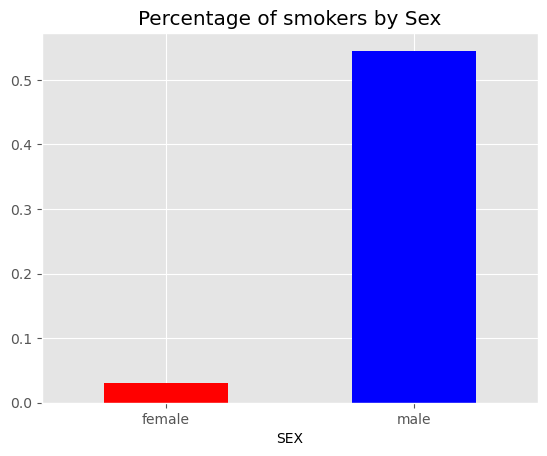

In [12]:
#여성 흡연자 비율 확인
temp = data.copy()
temp['SEX'] = temp['SEX'].map({1:'male',2:'female'})
temp.groupby('SEX')['SMK_STAT'].value_counts(normalize=True)[:,1].plot.bar(color=['red','blue'])
plt.xticks(rotation=0)
plt.title('Percentage of smokers by Sex');

성별에 따른 흡연자 비율을 시각화해보았습니다.
남성 흡연자 비율은 절반을 넘긴 반면, 여성 흡연자 비율은 5%가 채 되지 않습니다.

이 경우, 모델이 여성 데이터에 대해 전부 '비흡연자'로 예측할 가능성이 높습니다.
이런 식의 편향된 예측은 프로젝트의 목적에 부합하지 않으며,
애초에 성별이 건강검진의 '결과'에 속한다고 보기 어렵습니다.
따라서 성별(SEX) 피처는 분석 전에 삭제하도록 하겠습니다.

그 다음에 주목할 피처는 키(HEIGHT)입니다.
키를 140cm 부터 10cm 단위로 그룹지어 흡연자 비율을 시각화해보겠습니다.

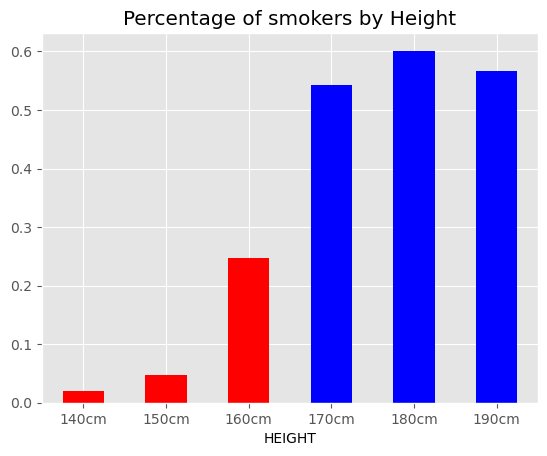

In [13]:
#표본이 너무 적은 키 140 미만 데이터 제외
temp = data.query("HEIGHT >= 140")

#키에 대해서 10cm 단위로 그룹화
temp['HEIGHT'] = (temp['HEIGHT'] // 10 * 10).astype(int).astype(str) + 'cm'

#그룹화된 데이터에 대해 시각화
temp.groupby('HEIGHT')['SMK_STAT'].value_counts(normalize=True).loc[:,1].plot.bar(color=['red','red','red','blue','blue','blue'])
plt.xticks(rotation=0)
plt.title('Percentage of smokers by Height');

위 그래프를 보시면 키가 170cm를 넘는 집단의 경우 흡연률이 절반을 넘는 반면,
170cm 아래로는 흡연율이 급감하는 모습을 확인할 수 있습니다.

그렇다면 정말 흡연과 키 사이에 유의미한 상관관계가 있다고 할 수 있을까요?

성별과 키의 상관계수 (절댓값) : 0.7155383469128458


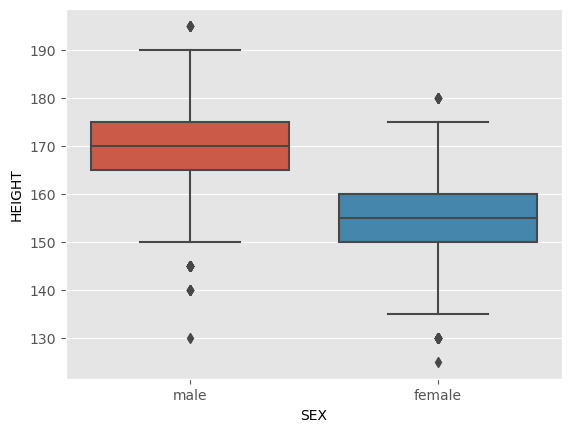

In [14]:
print(f'성별과 키의 상관계수 (절댓값) : {abs(data[["SEX","HEIGHT"]].corr().iloc[1][0])}')

temp = data.copy()
temp['SEX'] = temp['SEX'].map({1:'male',2:'female'})

#성별에 따른 키 분포 상자그림
sns.boxplot(data=temp, x='SEX', y='HEIGHT');

사실 키와 유의미한 관계가 있는 것은 '성별'입니다. (상관계수 절댓값이 0.7 이상)

위의 상자 그래프만 보더라도 남성(1)의 키 분포와 여성(2)의 키 분포의 차이가 많이 나는 것을 알 수 있습니다.

즉, 키가 작은 집단에는 여성의 비율이 높고, 여성의 경우 비흡연자의 비율이 압도적으로 높으므로,
키가 작은 집단일수록 비흡연자의 비율이 높아질 수 밖에 없습니다.

그렇다면 성별 피처를 제거했을 때, 모델은 키가 작을 수록 비흡연자에 편향된 예측을 할 가능성이 높습니다.

따라서, 성별(SEX) 피처와 강한 상관관계를 가진 키(HEIGHT) 피처도 함께 삭제되어야 합니다.

그렇다면 몸무게(WEIGHT)는 어떨까요?

키와 몸무게의 상관계수 (절댓값) : 0.6569111894838294
성별과 몸무게의 상관계수 (절댓값) : 0.5625054898539277


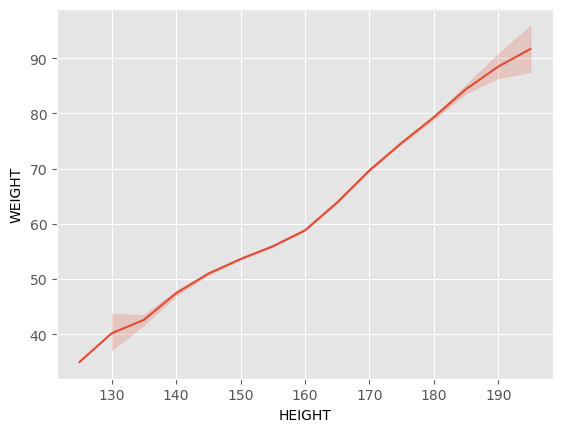

In [15]:
print(f'키와 몸무게의 상관계수 (절댓값) : {abs(data[["WEIGHT","HEIGHT"]].corr().iloc[1][0])}')
print(f'성별과 몸무게의 상관계수 (절댓값) : {abs(data[["WEIGHT","SEX"]].corr().iloc[1][0])}')
sns.lineplot(data=data,x='HEIGHT',y='WEIGHT');

위의 상관계수와 그래프로 보아, 키와 몸무게 역시 강한 상관관계를 가지고 있다고 할 수 있습니다.
또한, 성별과 몸무게의 상관계수도 0.5를 넘으면서 어느 정도 관계가 있다고 할 수 있습니다.

저희가 몸무게 피처로부터 알아내고자 하는 정보는 비만(혹은 저체중)의 정도이지,
모델로 하여금 성별을 예측해서 편향되게 흡연자/비흡연자 구분을 하는 것을 원하지는 않습니다.

그렇다면 몸무게 피처도 삭제해야 할까요?

In [16]:
#몸무게(WEIGHT)를 BMI로 대체
data['WEIGHT'] = data['WEIGHT'] / (data['HEIGHT']*0.01)**2
data.rename(columns={'WEIGHT':"BMI"},inplace=True)
print(f'BMI와 키의 상관계수 (절댓값) : {abs(data[["BMI","HEIGHT"]].corr().iloc[1][0])}')
print(f'BMI와 성별의 상관계수 (절댓값) : {abs(data[["BMI","SEX"]].corr().iloc[1][0])}')

BMI와 키의 상관계수 (절댓값) : 0.060240209983210356
BMI와 성별의 상관계수 (절댓값) : 0.16424807822808324


대신에 더 좋은 방법이 있습니다. 바로 BMI 지수를 이용하는 것입니다.

[BMI 공식 : 몸무게 / ((키*0.01) 의 제곱)]

몸무게 피처를 BMI 지수로 대체하면, 어느 정도 상관관계를 줄일 수 있습니다.
실제로 몸무게를 BMI 지수로 대체한 결과, 성별과의 상관계수가 기존의 3분의 1도 안 되는 수준으로 줄어들었습니다.

따라서 BMI 지수 피처는 놔두고, 성별과 키 피처만 삭제하도록 하겠습니다.

In [18]:
#성별과 함께 키 열 삭제
data.drop(['HEIGHT','SEX'],axis=1,inplace=True)
data.head(5)

,AGE_GROUP,BMI,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,BP_LWST,BLDS,...,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT
0,4,27.548209,83.0,1.2,1.5,1.0,1.0,118.0,73.0,82.0,...,446.0,45.0,59.0,15.6,1.0,1.2,34.0,48.0,202.0,1
1,7,22.857143,88.0,1.2,1.0,1.0,1.0,144.0,93.0,94.0,...,142.0,55.0,98.0,15.5,1.0,0.8,24.0,24.0,34.0,1
3,9,22.959184,72.0,0.8,0.5,1.0,1.0,104.0,59.0,85.0,...,130.0,62.0,106.0,12.2,1.0,0.9,21.0,15.0,20.0,0
4,7,31.217482,86.0,0.8,0.9,1.0,1.0,105.0,70.0,81.0,...,113.0,60.0,147.0,9.2,1.0,0.7,29.0,25.0,33.0,0
5,7,22.038567,80.0,0.8,1.0,1.0,1.0,140.0,90.0,110.0,...,84.0,65.0,109.0,15.4,1.0,1.0,20.0,20.0,51.0,1


다음으로 확인할 피처는 왼쪽 시력(SIGHT_LEFT)과 오른쪽 시력(SIGHT_RIGHT)입니다.

변수 정보를 확인해 본 결과, 실명인 경우 0이 아니라 9.9라는 대체값이 사용되었습니다.
따라서 9.9를 가진 행의 경우, 그 값을 구분할 수 있도록 -1로 대체하겠습니다.

In [19]:
#왼쪽 시력(SIGHT_LEFT)과 오른쪽 시력(SIGHT_RIGHT)열에 대하여 실명 여부 반영
data.loc[data['SIGHT_LEFT']==9.9,'SIGHT_LEFT'] = -1
data.loc[data['SIGHT_RIGHT']==9.9,'SIGHT_RIGHT'] = -1

이제 피처들은 어느 정도 정리가 된 것 같으니, 이제 남은 결측값 처리로 넘어가겠습니다.

In [20]:
#피처별 결측값 확인
data.isnull().sum()

AGE_GROUP            0
BMI                  8
WAIST               11
SIGHT_LEFT          17
SIGHT_RIGHT         17
HEAR_LEFT           13
HEAR_RIGHT          14
BP_HIGH            157
BP_LWST            157
BLDS               159
TOT_CHOLE        14566
TRIGLYCERIDE     14565
HDL_CHOLE        14566
LDL_CHOLE        15085
HMG                158
OLIG_PROTE_CD      619
CREATININE         158
SGOT_AST           158
SGPT_ALT           158
GAMMA_GTP          158
SMK_STAT             0
dtype: int64

현재 8개 정도의 피처에서 거의 비슷하게 190개 행 정도에 결측값이 있고,

콜레스테롤(CHOLE) 관련 피처 및 중성지방(TRIGLYCERIDE) 피처에 약 2만개 행에 가까운 결측값이 있습니다.

그렇다면 먼저 결측값이 많은 행들의 비율을 알아보겠습니다.

In [21]:
print(f'결측값이 6개 이상인 행의 비율 : {round((data.isnull().sum(1) >= 6).sum() / len(data),3)*100}%')
print(f'결측값이 5개 이상인 행의 비율 : {round((data.isnull().sum(1) >= 5).sum() / len(data),3)*100}%')
print(f'결측값이 4개 이상인 행의 비율 : {round((data.isnull().sum(1) >= 4).sum() / len(data),3)*100}%')

결측값이 6개 이상인 행의 비율 : 0.2%
결측값이 5개 이상인 행의 비율 : 0.3%
결측값이 4개 이상인 행의 비율 : 14.899999999999999%


결측값이 4개 이상인 행의 비율은 전체의 16%에 가까운 반면,
결측값이 5개 이상인 행의 비율은 0.3%에 불과합니다.

아마도 이 행들이 위의 표에서 동시에 결측값이 많이 발생한 190개 행이 되는 것 같습니다.
이 행들의 전체 비율은 상대적으로 작은 편이고, 한 행의 너무 많은 피처들이 결측값으로 대체되는 것은 바람직하지 않습니다.

따라서 결측값이 5개 이상인 행은 일괄적으로 삭제하겠습니다.

In [22]:
#한 행의 결측값이 아닌 값이 17개에 못 미치는 행 삭제 
data.dropna(thresh=17,inplace=True)
data.head(5)

,AGE_GROUP,BMI,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,BP_LWST,BLDS,...,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT
0,4,27.548209,83.0,1.2,1.5,1.0,1.0,118.0,73.0,82.0,...,446.0,45.0,59.0,15.6,1.0,1.2,34.0,48.0,202.0,1
1,7,22.857143,88.0,1.2,1.0,1.0,1.0,144.0,93.0,94.0,...,142.0,55.0,98.0,15.5,1.0,0.8,24.0,24.0,34.0,1
3,9,22.959184,72.0,0.8,0.5,1.0,1.0,104.0,59.0,85.0,...,130.0,62.0,106.0,12.2,1.0,0.9,21.0,15.0,20.0,0
4,7,31.217482,86.0,0.8,0.9,1.0,1.0,105.0,70.0,81.0,...,113.0,60.0,147.0,9.2,1.0,0.7,29.0,25.0,33.0,0
5,7,22.038567,80.0,0.8,1.0,1.0,1.0,140.0,90.0,110.0,...,84.0,65.0,109.0,15.4,1.0,1.0,20.0,20.0,51.0,1


In [23]:
#피처별 결측값 확인
data.isnull().sum()

AGE_GROUP            0
BMI                  7
WAIST                2
SIGHT_LEFT          12
SIGHT_RIGHT         11
HEAR_LEFT           10
HEAR_RIGHT          11
BP_HIGH              1
BP_LWST              1
BLDS                 0
TOT_CHOLE        14321
TRIGLYCERIDE     14320
HDL_CHOLE        14321
LDL_CHOLE        14840
HMG                  0
OLIG_PROTE_CD      385
CREATININE           0
SGOT_AST             0
SGPT_ALT             0
GAMMA_GTP            0
SMK_STAT             0
dtype: int64

다음으로 확인해 볼 피처는 왼쪽 청력/오른쪽 청력 입니다.
두 피처에서 각각 12,13개의 결측값이 존재합니다.

In [24]:
print(f'왼쪽 청력 이상 여부)  \n{data["HEAR_LEFT"].value_counts()}\n')
print(f'오른쪽 청력 이상 여부)  \n{data["HEAR_RIGHT"].value_counts()}')

왼쪽 청력 이상 여부)  
1.0    94796
2.0     2786
3.0        9
Name: HEAR_LEFT, dtype: int64

오른쪽 청력 이상 여부)  
1.0    94905
2.0     2670
3.0       15
Name: HEAR_RIGHT, dtype: int64


그런데 데이터를 확인해보니 범주가 3가지(1~3)으로 구분되어 있습니다.

변수 정보에는 정상이 1, 비정상이 2라고 되어있는데 3이 무엇을 뜻하는지 어디에도 나와있지 않습니다.

아무래도 3의 경우 검사에 이상이 있거나 실시하지 못해서 대체값을 표기한 것으로 봐야 할 것 같습니다.

결측값과 함께 3에 대해서는, 비율이 압도적으로 높은 1(정상)로 대체하도록 하겠습니다.

In [25]:
#결측값과 이상치에 대하여 최빈값으로 대체
data["HEAR_LEFT"] = np.where((data["HEAR_LEFT"] == 3) | (data["HEAR_LEFT"].isnull()), 1, data["HEAR_LEFT"])
data["HEAR_RIGHT"] = np.where((data["HEAR_RIGHT"] == 3) | (data["HEAR_RIGHT"].isnull()), 1, data["HEAR_RIGHT"])

In [26]:
print(f'왼쪽 청력 이상 여부)  \n{data["HEAR_LEFT"].value_counts()}\n')
print(f'오른쪽 청력 이상 여부)  \n{data["HEAR_RIGHT"].value_counts()}')

왼쪽 청력 이상 여부)  
1.0    94815
2.0     2786
Name: HEAR_LEFT, dtype: int64

오른쪽 청력 이상 여부)  
1.0    94931
2.0     2670
Name: HEAR_RIGHT, dtype: int64


이제 결측값이 2만 행 가까이 발생한 콜레스테롤 및 중성지방 피처들을 처리해야 합니다.

2만행은 전체의 약 16%의 달하는 많은 양의 데이터이므로,
함부로 결측값 대체를 시도했다가는 모델의 성능이 크게 저하될 수 있습니다.

그렇다면 선택할 수 있는 방안은 아래 2가지입니다.

1. 결측값이 발생한 약 1만 4천 행들을 삭제한다.

2. 해당 피처 4개를 삭제한다.

그런데, 어떤 선택지가 더 나은 결과를 가져올 지 확신할 수 없습니다.
그렇기 때문에 현재 데이터셋에 대하여 위 방안 중 각각 하나씩을 적용해 두 개의 임시 데이터셋을 만들겠습니다.

In [27]:
#결측값이 발생한 2만 행을 삭제한 데이터
A_data = data.dropna(subset=['TOT_CHOLE','TRIGLYCERIDE','HDL_CHOLE','LDL_CHOLE'])

#결측값이 발생된 피처를 제거한 데이터
B_data = data.drop(['TOT_CHOLE','TRIGLYCERIDE','HDL_CHOLE','LDL_CHOLE'],axis=1)

In [28]:
print(f'A_data 크기 : {A_data.shape}')
print(f'B_data 크기 : {B_data.shape}')

A_data 크기 : (82761, 21)
B_data 크기 : (97601, 17)


A_data는 대략 15000 행이 삭제되었으며,
B_data는 4개의 피처가 삭제되었습니다.

이제 남은 피처들의 결측값 행들은 그 수가 매우 적으므로,
일괄적으로 중앙값을 이용해 결측값으로 대체하도록 하겠습니다.

(이상치의 영향을 적게 받도록 하기 위해, 평균 대신 중앙값을 이용하여 대체하겠습니다.)

In [29]:
#각 데이터별로 중앙값을 이용하여 결측값 대체
A_data.fillna(A_data.median(),inplace=True)
B_data.fillna(B_data.median(),inplace=True)

이제 서로 다른 두 가지 방안을 적용한 A_data, B_data에 대해 가벼운 모델을 적용하여
어떤 데이터로 훈련했을 때 성능이 더 좋은지 비교해도록 해보겠습니다.

* 시험에 사용할 모델은 랜덤포레스트로 정했습니다.
(별도의 튜닝 및 데이터 표준화 없이도 안정적인 성능을 기대할 수 있기 때문에 선택)

* 간단한 시험이 목적이므로, 별도의 모델 튜닝없이 기본값의 모델을 사용하겠습니다.

* 비흡연자/흡연자 비율이 불균형하므로, 정확도 대신 F1 score를 비교하겠습니다.
(정확도는 데이터 비율이 불균형할 때 편향된 예측에 더 높게 나타날 수 있습니다.
그 대신, 정밀도와 재현율을 둘 다 고려한 F1 score를 더 신뢰할 수 있는 지표로 사용할 수 있습니다.)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

x = A_data.drop('SMK_STAT',axis=1).values
y = A_data['SMK_STAT'].values

A_score = [] #결과값을 집어넣을 리스트

for i in range(5): #random_state를 바꿔가며 5번 테스트 후 결과값 평균
    x_train, x_valid, y_train, y_valid = train_test_split(x,y,stratify=y,test_size=0.1,random_state=i**i)

    tree = RandomForestClassifier(n_estimators=300, n_jobs=-1) #n_estimators는 컴퓨터 성능을 고려하여 적당한 수

    tree.fit(x_train,y_train)
    y_pred=tree.predict(x_valid)
    A_score.append(f1_score(y_valid,y_pred))

print(f'A_data 모델의 F1 score 평균 : {pd.Series(A_score).mean()}')

A_data 모델의 F1 score 평균 : 0.6206562603806509


In [31]:
x = B_data.drop('SMK_STAT',axis=1).values
y = B_data['SMK_STAT'].values

B_score = [] #결과값을 집어넣을 리스트

for i in range(5): #random_state를 바꿔가며 5번 테스트 후 결과값 평균
    x_train, x_valid, y_train, y_valid = train_test_split(x,y,stratify=y,test_size=0.1,random_state=i**i)

    tree = RandomForestClassifier(n_estimators=300, n_jobs=-1) #n_estimators는 컴퓨터 성능을 고려하여 적당한 수

    tree.fit(x_train,y_train)
    y_pred=tree.predict(x_valid)
    B_score.append(f1_score(y_valid,y_pred))

print(f'B_data 모델의 F1 score 평균 : {pd.Series(B_score).mean()}')

B_data 모델의 F1 score 평균 : 0.6120291884052215


근소한 차이로 A_data로 훈련한 모델의 F1 score가 더 높게 나왔습니다.

따라서, 앞으로의 분석에서는 콜레스테롤 및 중성지방 관련 4개 피처가 결측된 행들은 삭제한 데이터를
사용하도록 하겠습니다.

* 중간 결론 1 : 콜레스테롤 및 중성지방 관련 4개 피처가 결측된 행 제거

In [32]:
data = A_data.copy()

이제 본격적인 데이터 모델링을 시작하기 전에 필요한 몇 가지를 하도록 하겠습니다.

첫 번째는 현재 데이터에서 별도의 테스트 데이터셋과 검증 데이터셋을 분리하는 것입니다.

테스트 데이터셋은 데이터 가공 및 모델의 최종 튜닝이 모두 완료된 후에,
최종적으로 모델에 기대할 수 있는 정확도를 측정하기 위해 사용할 예정입니다.

반면 검증 데이터셋의 경우, 모델 선택 및 튜닝 과정에서 반복적으로 예측 성능을 알아보기 위해
사용할 예정입니다.

In [33]:
from sklearn.model_selection import train_test_split
x = data.drop('SMK_STAT',axis=1).values
y = data['SMK_STAT'].values

#테스트 데이터 분리
x, x_test, y, y_test = train_test_split(x,y,stratify=y,test_size=0.1,random_state=2023)

#검증 데이터 분리
x_train, x_valid, y_train, y_valid = train_test_split(x,y,stratify=y,test_size=0.1,random_state=2023)

테스트 데이터와 검증 데이터를 각각 10%의 비율로 추출했습니다.

샘플 수가 적었다면 더 높은 비율로 추출해야 했겠지만, 지금의 데이터 상황을 고려했을 때 이정도면 충분한 것 같습니다.

그 다음으로 할 작업은 데이터를 리샘플링하는 것입니다.

리샘플링을 해야 하는 이유는 아래 그래프를 보면 알 수 있습니다.

Text(0.5, 1.0, 'Percentage of smokers')

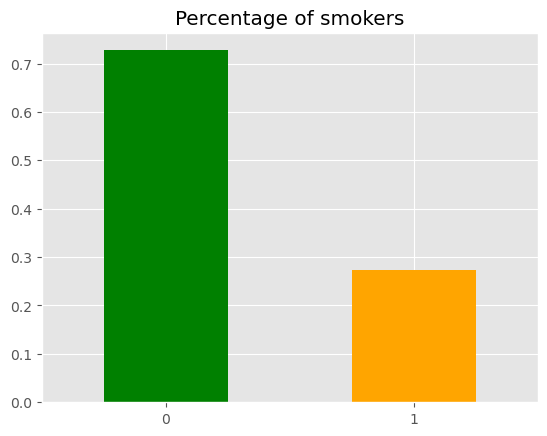

In [34]:
#흡연자/비흡연자 비율
pd.Series(y_train).value_counts(normalize=True).plot.bar(color=['green','orange'])
plt.xticks(rotation=0)
plt.title('Percentage of smokers')

현재 데이터의 흡연자(1) 비율이 비흡연자(0)의 절반도 되지 않습니다.

위에서 언급했던 것처럼 이렇게 데이터가 불균형한 경우,
모델을 평가하는 과정에서 정확도 대신 F1 score를 사용하는 방법도 있습니다.

그러나 F1 score는 정확도와 달리, 지표가 확 와닿지 않는다는 문제점이 있습니다.

예를 들어 정확도(Accuracy)가 0.7이다! 라고 한다면, (테스트) 데이터의 70%에 대해서 그 예측이 맞았다라고 해석할 수 있습니다.

하지만 F1 score가 0.7이다! 라고 해도, "크면 클수록 좋다" 이상의 해석이 어렵습니다.

따라서 F1 score를 사용하는 대신, 흡연자의 데이터를 비흡연자의 수만큼 복원추출하여 균형을 맞추는 '리샘플링'을 하도록 하겠습니다.

In [35]:
from sklearn.utils import resample

#흡연자 데이터를 비흡연자 수만큼 복원추출하여 균형 맞추기
re_x, re_y = resample(x_train[y_train==1],
                      y_train[y_train==1],
                      replace=True,
                      n_samples=x_train[y_train==0].shape[0],
                      random_state=392)

#비흡연자 데이터와 불려진 흡연자 데이터 합체
x_train = np.vstack((x_train[y_train==0],re_x))
y_train = np.hstack((y_train[y_train==0],re_y))

In [36]:
#비흡연자/흡연자 비율 확인 
pd.Series(y_train).value_counts()

0    48756
1    48756
dtype: int64

그 다음으로 훈련용 데이터에 대해 표준화를 진행하도록 하겠습니다.

표준화에는 사이킷런의 StandardScaler를 사용하겠습니다.

StandardScaler는 각 피처별로 평균과 표준편차를 구하고, 개별 값에서 평균을 빼고 표준편차로 나누어,
개별 피처를 평균이 0이고 분산이 1인 정규분포로 변환해줍니다.

표준화를 하지 않으면, 일부 모델에서 값의 범위(스케일)가 큰 피처의 영향력이 커질 수 있기에,
가급적이면 해주는게 좋습니다.

In [37]:
from sklearn.preprocessing import StandardScaler

#데이터 표준화 진행
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

#검증 데이터의 경우, 훈련 데이터의 평균과 표준편차를 이용하여 표준화
x_valid = sc.transform(x_valid)

지금부터 여러 가지 모델을 훈련하고 그 예측 정확도를 비교하여
최종적으로 사용할 모델은 선택하겠습니다.

모델 선택 #1
---

먼저 첫 번째로 테스트해 볼 모델은 로지스틱 회귀입니다.
이름에 '회귀'가 들어가지만, 분류에 사용됩니다.

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.linear_model import LogisticRegression

#규제 파라미터 C의 서치 범위를 제공하기 위해 로그균등분포 사용
dist = loguniform(0.0001,1000.0)

param_dist = [{'C':dist, #규제 파라미터
               'solver':['lbfgs', 'liblinear','newton-cholesky']}] #비용함수 최적화 방법

lr = LogisticRegression()

#연속형 파라미터가 포함되어 있어서 랜덤서치 사용
search = RandomizedSearchCV(estimator=lr,
                            param_distributions=param_dist,
                            n_iter=100,
                            cv=5,
                            n_jobs=-1,
                            random_state=202)

search.fit(x_train,y_train)

lr_best = search.best_estimator_

print(f'로지스틱 회귀 모델의 훈련 정확도 : {round(search.score(x_train,y_train)*100,3)}%')
print(f'로지스틱 회귀 모델의 검증 정확도 : {round(search.score(x_valid,y_valid)*100,3)}%')

로지스틱 회귀 모델의 훈련 정확도 : 78.615%
로지스틱 회귀 모델의 검증 정확도 : 78.789%


모델의 훈련 정확도와 검증 정확도가 크게 차이나지 않습니다.
적어도 과대적합되지는 않았다는 사실을 알 수 있습니다.

그 다음으로, 가우시안 나이브 베이즈는 조건부 독립 가정과 베이즈 이론을 토대로 한 모델입니다.
훈련 속도가 매우 빠른 편입니다.

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.naive_bayes import GaussianNB

#규제 파라미터 C의 서치 범위를 제공하기 위해 로그균등분포 사용
param_dist = [{'var_smoothing' : loguniform(1e-12, 1e-6)}] #계산 안정성 조정

gnb = GaussianNB()

#연속형 파라미터가 포함되어 있어서 랜덤서치 사용
search = RandomizedSearchCV(estimator=gnb,
                            param_distributions=param_dist,
                            n_iter=100,
                            cv=5,
                            n_jobs=-1,
                            random_state=202)

search.fit(x_train,y_train)

gnb_best = search.best_estimator_ 

print(f'가우시안 나이브 베이즈 모델의 훈련 정확도 : {round(search.score(x_train,y_train)*100,3)}%')
print(f'가우시안 나이브 베이즈 모델의 검증 정확도 : {round(search.score(x_valid,y_valid)*100,3)}%')

가우시안 나이브 베이즈 모델의 훈련 정확도 : 73.872%
가우시안 나이브 베이즈 모델의 검증 정확도 : 72.453%


로지스틱 회귀에 비하면 결과가 다소 아쉬운 결과가 나왔습니다.

한편, 랜덤포레스트는 전체 샘플에서 데이터를 복원 추출하여 여러 개의 의사결정나무를 만듭니다.

그 후, 각 나무들의 분류 결과를 집계하여 최종 결과를 내놓는 기법입니다.

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_dist = {'max_depth':[7,8,9]}

rftree = RandomForestClassifier(n_estimators=300,
                                n_jobs=-1,
                                random_state=2023,
                                criterion='gini')

search = GridSearchCV(estimator=rftree,
                      param_grid=param_dist,
                      cv=5,
                      n_jobs=-1)

search.fit(x_train,y_train)

rftree_best = search.best_estimator_ 

print(f'랜덤 포레스트 모델의 훈련 정확도 : {round(search.score(x_train,y_train)*100,3)}%')
print(f'랜덤 포레스트 모델의 검증 정확도 : {round(search.score(x_valid,y_valid)*100,3)}%')

랜덤 포레스트 모델의 훈련 정확도 : 82.64%
랜덤 포레스트 모델의 검증 정확도 : 78.628%


랜덤 포레스트의 max_depth를 None으로 풀어주면 과대적합이 발생해서,
이를 최대한 억제하면서 시도해본 결과 로지스틱 회귀와 비슷한 지금의 (검증)정확도로 타협했습니다.

다음으로, XGBoost는 부스팅 알고리즘이 쓰인 트리형 모델입니다.

부스팅이란, 여러 개의 깊이가 얕은 의사결정나무를 순차적으로 만들고, 이전의 오답에 가중치를 부여하면서
더 나은 분류 결과를 만들어 가는 알고리즘입니다.

In [41]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import RandomizedSearchCV

#코드의 실행 시간이 너무 길어져서, 별도의 파라미터 서치 없이 직접 조절
xgb = XGBRFClassifier(max_depth=8,
                      random_state=2023,
                      n_jobs=-1,
                      reg_alpha=0.02,
                      reg_lambda=0.005,
                      n_estimators=500,
                      learning_rate=0.05)

xgb.fit(x_train,y_train)

print(f'XGBoost 모델의 훈련 정확도 : {round(xgb.score(x_train,y_train)*100,3)}%')
print(f'XGBoost 모델의 검증 정확도 : {round(xgb.score(x_valid,y_valid)*100,3)}%')

XGBoost 모델의 훈련 정확도 : 82.117%
XGBoost 모델의 검증 정확도 : 78.212%


훈련 정확도와 검증 정확도가 랜덤 포레스트와 거의 비슷하게 나타났습니다.
코드의 실행시간이 너무 길어져서 서치를 못했지만, 세세하게 서치했다면 더 좋은 결과가 나왔을 것 같습니다.

다음으로 살펴볼 lightGBM 또한 XGBoost와 마찬가지로 부스팅 알고리즘을 사용하는 트리 기반의 모델입니다.

그러나 lightGBM의 경우 XGBoost와 달리, 트리를 생성하는 매커니즘에 차이가 있습니다.
대체로 속도가 더 빠르다고 알려져있습니다.

In [42]:
from lightgbm import LGBMClassifier
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV

dist = loguniform(0.0001,1.0) #규제 파라미터 서치 범위를 위한 로그균등분포

param_dist = {'reg_lambda': dist, #l2 규제 파라미터
              'reg_alpha' : dist} #l1 규제 파라미터

lgbm = LGBMClassifier(n_estimators=400,
                      learning_rate=0.05,
                      random_state=124,
                      objective='binary',
                      num_leaves=50,
                      max_depth=-1)

search = RandomizedSearchCV(estimator=lgbm,
                            param_distributions=param_dist,
                            n_iter=50, 
                            cv=5,
                            n_jobs=-1,
                            random_state=26)

search.fit(x_train,y_train)
lgbm_best = search.best_estimator_ 

print(f'lightGBM 모델의 훈련 정확도 : {round(search.score(x_train,y_train)*100,3)}%')
print(f'lightGBM 모델의 검증 정확도 : {round(search.score(x_valid,y_valid)*100,3)}%')

lightGBM 모델의 훈련 정확도 : 86.6%
lightGBM 모델의 검증 정확도 : 80.494%


지금까지 시도했던 모델 중에서 검증 정확도가 가장 높게 나왔습니다.
또한, XGBoost와 비교하면 확실히 훈련 속도가 빨랐습니다.

마지막으로 확인해 볼 모델은 'k-최근접 이웃'입니다.

분류하려는 샘플로부터 가장 가까운 k개 이웃 샘플 중, 그 갯수가 가장 많은 집단에 해당 샘플을 할당합니다.

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_dist = {'n_neighbors' : [3,4,5,6,7]} #확인할 이웃한 샘플 개수 

knn = KNeighborsClassifier()

search = GridSearchCV(estimator=knn,
                      param_grid=param_dist,
                      cv=5,
                      n_jobs=-1)

search.fit(x_train,y_train)

knn_best = search.best_estimator_ 

print(f'k-최근접 이웃 모델의 훈련 정확도 : {round(search.score(x_train,y_train)*100,3)}%')
print(f'k-최근접 이웃 모델의 검증 정확도 : {round(search.score(x_valid,y_valid)*100,3)}%')

k-최근접 이웃 모델의 훈련 정확도 : 91.55%
k-최근접 이웃 모델의 검증 정확도 : 72.882%


훈련 정확도와 검증 정확도 차이가 거의 20% 가량 납니다.
확실히 과대적합 되어있지만, n_neighbors를 조절해서 지금보다 더 높은 검증 정확도를 낼 수 없었습니다.

모델 선택 #2
---

78% 이상의 검증 정확도를 보인 모델은
* 랜덤 포레스트
* lightGBM
* XGBoost
* 로지스틱 회귀

이렇게 네 개입니다.
네 모델 중 세 개나 트리형 모델이었습니다.

그렇다면 이 모델들 간의 예측이 얼마나 일치하는지 확인해보겠습니다.

In [44]:
# 서치를 통해 최선의 파라미터가 적용된 모델로부터 검증 데이터 예측 리스트
lgbm_pred = lgbm_best.predict(x_valid)
xgb_pred = xgb.predict(x_valid)
rftree_pred = rftree_best.predict(x_valid)
lr_pred = lr_best.predict(x_valid)

#결과가 가장 좋았던 lightGBM과 나머지 모델들 간에 예측 일치율
print('lightGBM와의 예측 일치율 :')
print(f'XGBoost : {round((lgbm_pred == xgb_pred).sum()/len(rftree_pred)*100,3)}%')
print(f'로지스틱 회귀 : {round((lgbm_pred == lr_pred).sum()/len(rftree_pred)*100,3)}%')
print(f'랜덤포레스트 : {round((lgbm_pred == rftree_pred).sum()/len(rftree_pred)*100,3)}%')

lightGBM와의 예측 일치율 :
XGBoost : 93.529%
로지스틱 회귀 : 91.422%
랜덤포레스트 : 93.731%


각 모델 간에 예측 정확도 차이가 2% 정도만 나는 것에 비해,
각 모델 사이에 예측 일치율이 90% 초반 정도에 머물고 있습니다.

그렇다면 각 모델이 내놓은 예측을 종합하여, 하나의 예측을 내놓는 '보팅'을 활용하면 
성능 향상이 가능한지 확인해보도록 하겠습니다.

보팅은 각 모델의 예측값만 이용하는 '하드 보팅'과 
예측 확률을 이용하는 '소프트 보팅'으로 나뉘며, 일반적으로 더 높은 성능을 기대할 수 있는
'소프트 보팅'을 선택하도록 하겠습니다.

In [45]:
from sklearn.ensemble import VotingClassifier

#3개 트리 모델에 대해 보팅 객체 생성
voting = VotingClassifier([('xgb',xgb),('lgbm',lgbm_best),('rftree',rftree_best),('lr',lr_best)],
                          n_jobs=-1,
                          voting='soft')

voting.fit(x_train,y_train)

print(f'보팅의 검증 정확도 : {round(voting.score(x_valid,y_valid)*100,3)}%')

보팅의 검증 정확도 : 79.876%


근소한 차이로 보팅의 정확도가 lightGBM의 정확도보다 낮습니다.

따라서 서로 다른 모델 간 보팅을 통해 성능 향상을 기대할 수 없을 것 같습니다.

* 중간 결론 2 : 서로 다른 모델 간 보팅을 통한 모델 성능 향상 실패

또한, 앞으로는 3개의 모델 중 검증 정확도가 가장 높았고, 과대적합 현상이 없었던 lightGBM을 선택하겠습니다.

In [46]:
model = lgbm_best

다음으로 '특성(피처) 추출'을 통해 모델의 성능 향상이 가능한 지 확인해보도록 하겠습니다.

주성분 분석을 활용한 차원 축소
---

특성 추출이란 차원 축소의 방법 중 하나로,
원본 데이터셋의 특성(피처)을 추출하여 새로운 특성 공간으로 데이터를 변환합니다.
이때, 새롭게 변환된 피처는 원본의 그것과 달라지며,
그 수는 원본 데이터셋보다 같거나 적어집니다.

피처가 많은 데이터의 경우, 차원의 저주로 인해 모델의 성능이 떨어질 수 있는데,
차원 축소를 통해 이러한 차원의 저주가 다소 완화될 수 있습니다.

이번 프로젝트에서 특성 추출을 위해 사용할 기법은 '주성분 분석(PCA)'입니다.

In [47]:
from sklearn.decomposition import PCA

#현재 데이터로 lightGBM 학습
model.fit(x_train, y_train)

print(f'PCA 적용 이전 검증 정확도 : {round(model.score(x_valid,y_valid)*100,3)}%')

#분산 설명률 0.9 수준이 되도록 새로운 특성 공간의 차원 결정
pca = PCA(n_components=0.9, random_state=2023)

x_train_pca = pca.fit_transform(x_train)
x_valid_pca = pca.transform(x_valid)

model.fit(x_train_pca, y_train)

print(f'PCA(90%) 적용 이후 검증 정확도 : {round(model.score(x_valid_pca,y_valid)*100,3)}%')

#분산 설명률 0.8 수준이 되도록 새로운 특성 공간의 차원 결정
pca = PCA(n_components=0.8, random_state=2023)

x_train_pca = pca.fit_transform(x_train)
x_valid_pca = pca.transform(x_valid)

model.fit(x_train_pca, y_train)

print(f'PCA(80%) 적용 이후 검증 정확도 : {round(model.score(x_valid_pca,y_valid)*100,3)}%')

PCA 적용 이전 검증 정확도 : 80.494%
PCA(90%) 적용 이후 검증 정확도 : 79.353%
PCA(80%) 적용 이후 검증 정확도 : 77.769%


PCA를 이용하여 데이터셋을 더 적은 수의 특성공간으로 변환할 수록,
오히려 모델의 검증 정확도가 저하되는 것을 확인할 수 있습니다.

PCA는 데이터의 용량을 줄이기 위해서라면 유용할 수 있으나,
이번 프로젝트에서는 성능 향상 측면에서 도움이 되지 않았습니다.

* 중간 결론 3 : 주성분 분석을 통한 모델 성능 향상 실패

피처의 정상 범주를 고려한 스케일링
---

다음으로 시도해볼 것은 '정상 범주 스케일링'입니다.

자세한 설명은 보고서 파일을 참조해주시면 감사하겠습니다.

In [48]:
model.fit(x_train, y_train)

model.booster_.feature_importance(importance_type='gain').argsort() #lightGBM의 gain 타입 특성 중요도

array([ 6,  5, 15,  4,  3,  8,  9,  7, 17, 18, 13, 10, 11, 12,  2,  0,  1,
       16, 19, 14], dtype=int64)

제가 선택한 3개의 피처는 GAMMA_GTP, CREATININE, HMG 입니다.

특성 중요도가 가장 높은 OLIG_PROTE_CD(요단백)은 1~6 사이의 정수만 나타나는 범주형 변수이므로,
그 다음 순위인 CREATININE(크레아티닌)과 HMG(혈색소)를 선택했습니다.

나머지 하나는 가장 중요도가 낮은 SGPT_ALT(간 관련 수치)를 선택해보았습니다.

그럼 이제 특성들에 대해서 정상 범주를 고려하여 스케일링을 진행해보겠습니다.

그런데 HMG의 경우 성별에 따라 정상 수치의 범위가 다른데, 현재 사용하고 있는 데이터셋은 성별 피처를 삭제했었으므로 원본 데이터로 다시 돌아가야 합니다.

In [49]:
backup = data.copy()
data = raw_data.copy()
data.head(5)

,Unnamed: 0,YEAR,IDV_ID,SEX,AGE_GROUP,AREA_CODE,HEIGHT,WEIGHT,WAIST,SIGHT_LEFT,...,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT,DRK_YN,HCHK_CE_IN,CRS_YN,TTR_YN
0,285437,2009,297069,1,4,41,165.0,75.0,83.0,1.2,...,1.0,1.2,34.0,48.0,202.0,3.0,N,N,NaN,NaN
1,660095,2009,222353,1,7,41,175.0,70.0,88.0,1.2,...,1.0,0.8,24.0,24.0,34.0,3.0,Y,N,NaN,NaN
2,936773,2009,150310,1,11,46,160.0,55.0,77.0,0.8,...,1.0,0.8,22.0,18.0,12.0,2.0,N,Y,Y,Y
3,790463,2009,720146,2,9,26,140.0,45.0,72.0,0.8,...,1.0,0.9,21.0,15.0,20.0,1.0,N,N,NaN,NaN
4,691702,2009,535286,2,7,41,155.0,75.0,86.0,0.8,...,1.0,0.7,29.0,25.0,33.0,1.0,N,Y,NaN,Y


현재 사용하고 있던 데이터는 백업해두고,
원본 데이터를 불러와 다시 작업해보겠습니다.

먼저 이전에 진행했던 전처리에서 성별 피처는 놔둔채로 그대로 적용해보겠습니다.

In [50]:
#성별 피처는 남겨두고, 이전의 전처리 재수행
data.dropna(subset='SMK_STAT',inplace=True)
data = data.query('SMK_STAT != 2')
data['SMK_STAT'] = data['SMK_STAT'].map({1:0, 3:1})
data.drop(['Unnamed: 0','IDV_ID','YEAR','AREA_CODE'],axis=1,inplace=True)
data.drop(['HCHK_CE_IN','CRS_YN','TTR_YN'],axis=1,inplace=True)
data['DRK_YN'] = data['DRK_YN'].map({'Y':1,'N':0,'1':1,'0':0,'1.0':1,'0.0':0})
data.drop(['DRK_YN'],axis=1,inplace=True)
data['WEIGHT'] = data['WEIGHT'] / (data['HEIGHT']*0.01)**2
data.rename(columns={'WEIGHT':"BMI"},inplace=True)
data.drop(['HEIGHT'],axis=1,inplace=True)
data.loc[data['SIGHT_LEFT']==9.9,'SIGHT_LEFT'] = -1
data.loc[data['SIGHT_RIGHT']==9.9,'SIGHT_RIGHT'] = -1
data.dropna(thresh=17,inplace=True)
data["HEAR_LEFT"] = np.where((data["HEAR_LEFT"] == 3) | (data["HEAR_LEFT"].isnull()), 1, data["HEAR_LEFT"])
data["HEAR_RIGHT"] = np.where((data["HEAR_RIGHT"] == 3) | (data["HEAR_RIGHT"].isnull()), 1, data["HEAR_RIGHT"])
data.dropna(subset=['TOT_CHOLE','TRIGLYCERIDE','HDL_CHOLE','LDL_CHOLE'],inplace=True)
data.fillna(A_data.median(),inplace=True)
data.head(5)

,SEX,AGE_GROUP,BMI,WAIST,SIGHT_LEFT,SIGHT_RIGHT,HEAR_LEFT,HEAR_RIGHT,BP_HIGH,BP_LWST,...,TRIGLYCERIDE,HDL_CHOLE,LDL_CHOLE,HMG,OLIG_PROTE_CD,CREATININE,SGOT_AST,SGPT_ALT,GAMMA_GTP,SMK_STAT
0,1,4,27.548209,83.0,1.2,1.5,1.0,1.0,118.0,73.0,...,446.0,45.0,59.0,15.6,1.0,1.2,34.0,48.0,202.0,1
1,1,7,22.857143,88.0,1.2,1.0,1.0,1.0,144.0,93.0,...,142.0,55.0,98.0,15.5,1.0,0.8,24.0,24.0,34.0,1
3,2,9,22.959184,72.0,0.8,0.5,1.0,1.0,104.0,59.0,...,130.0,62.0,106.0,12.2,1.0,0.9,21.0,15.0,20.0,0
4,2,7,31.217482,86.0,0.8,0.9,1.0,1.0,105.0,70.0,...,113.0,60.0,147.0,9.2,1.0,0.7,29.0,25.0,33.0,0
5,1,7,22.038567,80.0,0.8,1.0,1.0,1.0,140.0,90.0,...,84.0,65.0,109.0,15.4,1.0,1.0,20.0,20.0,51.0,1


먼저, SGPT_ALT(간 관련 수치)에 대해 정상 범주 스케일링을 적용하겠습니다.

정상 수치 범위는 0에서 40 사이입니다.

In [51]:
#실제값에서 하한값을 빼고, 분모에 (상한 - 하한)값으로 나누기
data['SGPT_ALT'] = ((data['SGPT_ALT'] - 0) / (40 - 0))**2

마찬가지의 방법으로 HMG(혈색소), CREATININE(크레아티닌)에도 적용해보겠습니다.

CREATININE(크레아티닌)은 성별 관계없이 0.8에서 1.7 사이가 정상 수치 범주입니다.

HMG(혈색소)의 경우, 데이터셋 변수 소개에 정상 수치 범주가 나와있지 않았습니다.
따라서 구글링을 통해 연세 세브란스 헤모글로빈 페이지(https://medicine.yonsei.ac.kr/health/encyclopedia/treat_board.do?mode=view&articleNo=67009&title=%ED%97%A4%EB%AA%A8%EA%B8%80%EB%A1%9C%EB%B9%88)로부터 정상 수치 범주를 조사해왔습니다.

남성의 경우 13.5 ~ 17.5, 여성의 경우 12.5 ~ 15.5가 정상 수치 범주입니다.

In [52]:
#실제값에서 하한값을 빼고, 분모에 (상한 - 하한)값으로 나누기
data['CREATININE'] = (data['CREATININE'] - 0.8) / (1.7-0.8)
data['CREATININE'] = np.where(data['CREATININE'] < 0, (data['CREATININE']**2)*(-1), (data['CREATININE']**2))

#남성/여성 간 데이터 분리
male = data.loc[data['SEX']==1,'HMG']
female = data.loc[data['SEX']==2,'HMG']

#남성의 정상 범위는 13.5 ~ 17.5
male = ((male - 13.5)/(17.5-13.5))**2
male = np.where(male < 0, (male**2)*(-1), (male**2))

#여성의 정상 범위는 12.5 ~ 15.5
female = (female - 12.5)/(15.5-12.5)
female = np.where(female < 0, (female**2)*(-1), (female**2))

data.loc[data['SEX']==1,'HMG'] = male
data.loc[data['SEX']==2,'HMG'] = female

이제 이 데이터에서 다시 테스트, 검증 데이터를 분리하겠습니다.

In [53]:
temp = data.drop('SEX',axis=1)

rx = temp.drop('SMK_STAT',axis=1).values
ry = temp['SMK_STAT'].values

#현재 데이터에서 테스트 데이터셋 분리
rx, rx_test, ry, ry_test = train_test_split(rx,ry,stratify=ry,test_size=0.1,random_state=2023)

#현재 데이터에서 검증 데이터셋 분리
rx_train, rx_valid, ry_train, ry_valid = train_test_split(rx,ry,stratify=ry,test_size=0.1,random_state=2023)

#데이터 표준화
sc = StandardScaler()
rx_train = sc.fit_transform(rx_train)
rx_valid = sc.transform(rx_valid)

이렇게 정상 범주 스케일링을 적용한 데이터를 가지고 모델의 예측 정확도를 측정해보겠습니다.

In [54]:
model.fit(rx_train,ry_train)

print(f'정상 범주 스케일링 적용 후 검증 정확도 : {round(model.score(rx_valid,ry_valid)*100,3)}%')

정상 범주 스케일링 적용 후 검증 정확도 : 81.407%


정상 범주 스케일링을 적용한 결과, 검증 정확도가 약 1% 정도 상승했습니다.
이 1%의 상승이 오로지 정상 범주 스케일링의 덕분이라고 단정할 수는 없지만,

적어도 이러한 스케일링이 데이터를 손상시켜 모델의 성능을 저하시키지는 않았다고 판단할 수 있습니다.

그렇다면 나머지 변수들에도 이러한 스케일링을 적용하도록 하겠습니다.

In [55]:
#공복 혈당의 정상 범위는 70~99
data['BLDS'] = (data['BLDS'] - 70) / (99-70)
data['BLDS'] = np.where(data['BLDS']<0, (data['BLDS']**2)*(-1), (data['BLDS']**2))

#중성지방의 정상 범위는 30~135 사이
data['TRIGLYCERIDE'] = (data['TRIGLYCERIDE'] - 30) / (135-30)
data['TRIGLYCERIDE'] = np.where(data['TRIGLYCERIDE']<0, (data['TRIGLYCERIDE']**2)*(-1), (data['TRIGLYCERIDE']**2))

#BMI의 정상 범위는 18.5~23.5
data['BMI'] = (data['BMI'] - 18.5) / (23-18.5)
data['BMI'] = np.where(data['BMI']<0, (data['BMI']**2)*(-1), (data['BMI']**2))

#총콜레스테롤의 정상 범위는 150~250
data['TOT_CHOLE'] = (data['TOT_CHOLE'] - 150) / (250-150)
data['TOT_CHOLE'] = np.where(data['TOT_CHOLE']<0, (data['TOT_CHOLE']**2)*(-1), (data['TOT_CHOLE']**2))

#HDL콜레스테롤의 정상 범위는 30~65
data['HDL_CHOLE'] = (data['HDL_CHOLE'] - 65) / (65-30)
data['HDL_CHOLE'] = np.where(data['HDL_CHOLE']<0, (data['HDL_CHOLE']**2)*(-1), (data['HDL_CHOLE']**2))

#LDL콜레스테롤의 정상 범위는 170 이하
data['LDL_CHOLE'] = (data['LDL_CHOLE'] - 170) / (170-0)
data['LDL_CHOLE'] = np.where(data['LDL_CHOLE']<0, (data['LDL_CHOLE']**2)*(-1), (data['LDL_CHOLE']**2))

#SGOT_AST의 정상 범위는 40 이하
data['SGOT_AST'] = (data['SGOT_AST'] - 40) / (40-0)
data['SGOT_AST'] = np.where(data['SGOT_AST']<0, (data['SGOT_AST']**2)*(-1), (data['SGOT_AST']**2))

GAMMA_GTP(간 관련 수치)의 경우, 성별 간 정상 범주가 다르므로 따로 기준을 적용합니다.

In [56]:
#남성/여성 간 데이터 분리
male = data.loc[data['SEX']==1,'GAMMA_GTP']
female = data.loc[data['SEX']==2,'GAMMA_GTP']

#남성의 정상 범위는 11 ~ 64
male = ((male - 11)/(64-11))**2
male = np.where(male < 0, (male**2)*(-1), (male**2))

#여성의 정상 범위는 12.5 ~ 15.5
female = (female - 8)/(35-8)
female = np.where(female < 0, (female**2)*(-1), (female**2))

data.loc[data['SEX']==1,'GAMMA_GTP'] = male
data.loc[data['SEX']==2,'GAMMA_GTP'] = female

수축기 혈압(BP_HIGH)과 이완기 혈압(BP_LWST)의 경우, 이 둘을 동시에 고려하여 고혈압 여부를 진단합니다.

그런데 이 둘을 동시에 하나의 변수로 만들 수 있는 변환식 같은게 존재하는 것이 아니므로,
이 두 피처에 대해서는 별도의 스케일링 없이 그대로 사용하도록 하겠습니다.

그리고 청력, 시력과 같이 별도의 정상 기준이 없는 변수에는 스케일링을 적용하지 않겠습니다.

In [57]:
temp = data.drop('SEX',axis=1)

rx = temp.drop('SMK_STAT',axis=1).values
ry = temp['SMK_STAT'].values

#현재 데이터에서 테스트 데이터셋 분리
rx, rx_test, ry, ry_test = train_test_split(rx,ry,stratify=ry,test_size=0.1,random_state=2023)

#현재 데이터에서 검증 데이터셋 분리
rx_train, rx_valid, ry_train, ry_valid = train_test_split(rx,ry,stratify=ry,test_size=0.1,random_state=2023)

#데이터 표준화
sc = StandardScaler()
rx_train = sc.fit_transform(rx_train)
rx_valid = sc.transform(rx_valid)

model.fit(rx_train,ry_train)

print(f'정상 범주 스케일링 적용 후 검증 정확도 : {round(model.score(rx_valid,ry_valid)*100,3)}%')

정상 범주 스케일링 적용 후 검증 정확도 : 80.709%


적용할 수 있는 변수에 모두 적용하자, 오히려 검증 정확도가 감소했습니다.

그렇다면 모든 변수에 스케일링을 적용하는 대신, 이전의 3개 피처에만 스케일링을 적용했던 데이터를 사용하겠습니다.

* 중간 결론 4 : 일부 피처(HMG, CREATININE, SGPT_ALT)에 대해 정상 범주 스케일링 적용

아래 코드는 이전의 데이터를 다시 만드는 코드입니다.

In [58]:
backup = data.copy()
data = raw_data.copy()
data.head(5)

#이전의 전처리 재수행
data.dropna(subset='SMK_STAT',inplace=True)
data = data.query('SMK_STAT != 2')
data['SMK_STAT'] = data['SMK_STAT'].map({1:0, 3:1})
data.drop(['Unnamed: 0','IDV_ID','YEAR','AREA_CODE'],axis=1,inplace=True)
data.drop(['HCHK_CE_IN','CRS_YN','TTR_YN'],axis=1,inplace=True)
data['DRK_YN'] = data['DRK_YN'].map({'Y':1,'N':0,'1':1,'0':0,'1.0':1,'0.0':0})
data.drop(['DRK_YN'],axis=1,inplace=True)
data['WEIGHT'] = data['WEIGHT'] / (data['HEIGHT']*0.01)**2
data.rename(columns={'WEIGHT':"BMI"},inplace=True)
data.drop(['HEIGHT'],axis=1,inplace=True)
data.loc[data['SIGHT_LEFT']==9.9,'SIGHT_LEFT'] = -1
data.loc[data['SIGHT_RIGHT']==9.9,'SIGHT_RIGHT'] = -1
data.dropna(thresh=17,inplace=True)
data["HEAR_LEFT"] = np.where((data["HEAR_LEFT"] == 3) | (data["HEAR_LEFT"].isnull()), 1, data["HEAR_LEFT"])
data["HEAR_RIGHT"] = np.where((data["HEAR_RIGHT"] == 3) | (data["HEAR_RIGHT"].isnull()), 1, data["HEAR_RIGHT"])
data.dropna(subset=['TOT_CHOLE','TRIGLYCERIDE','HDL_CHOLE','LDL_CHOLE'],inplace=True)
data.fillna(A_data.median(),inplace=True)
data.head(5)

data['SGPT_ALT'] = ((data['SGPT_ALT'] - 0) / (40 - 0))**2
data['CREATININE'] = (data['CREATININE'] - 0.8) / (1.7-0.8)
data['CREATININE'] = np.where(data['CREATININE'] < 0, (data['CREATININE']**2)*(-1), (data['CREATININE']**2))
male = data.loc[data['SEX']==1,'HMG']
female = data.loc[data['SEX']==2,'HMG']
male = ((male - 13.5)/(17.5-13.5))**2
male = np.where(male < 0, (male**2)*(-1), (male**2))
female = (female - 12.5)/(15.5-12.5)
female = np.where(female < 0, (female**2)*(-1), (female**2))
data.loc[data['SEX']==1,'HMG'] = male
data.loc[data['SEX']==2,'HMG'] = female
data.drop('SEX',axis=1,inplace=True)

최종 모델 튜닝 및 테스트 정확도 확인
------

lightGBM을 최종 모델로 결정한 후, 
보팅, PCA, 스케일링 등 여러 방법을 시도해본 결과,
일부 피처에 정상 범주 스케일링을 적용했을 때 약간의 성능 향상이 있었습니다.
이 방법 이외에도 더 좋은 방법이 있겠지만, 제가 알고 있는 선에서 할 수 있는 방법은 전부 동원해본 것 같습니다.

그렇다면 현재 데이터셋에서 lightGBM 모델을 마지막으로 튜닝하고,
테스트 데이터셋을 이용하여 최종(테스트) 정확도를 측정해보겠습니다.

In [59]:
from sklearn.model_selection import train_test_split
x = data.drop('SMK_STAT',axis=1).values
y = data['SMK_STAT'].values

#이전과 동일한 random_state로 테스트 데이터 분리
x, x_test, y, y_test = train_test_split(x,y,stratify=y,test_size=0.1,random_state=2023)

#현재 데이터셋에 표준화 적용
sc = StandardScaler()
x = sc.fit_transform(x)
x_test = sc.transform(x_test)

#검증 데이터 분리 없이 리샘플링
re_x, re_y = resample(x[y==1],
                      y[y==1],
                      replace=True,
                      n_samples=x[y==0].shape[0],
                      random_state=2023)

#비흡연자 데이터와 불려진 흡연자 데이터 합체
x = np.vstack((x[y==0],re_x))
y = np.hstack((y[y==0],re_y))

In [60]:
from lightgbm import LGBMClassifier

dist = loguniform(0.0001,1000.0)

param_dist = {'reg_lambda' : dist, #l2 규제 파라미터
              'reg_alpha' : dist} #l1 규제 파라미터

#n_estimators를 늘리고, learning_rate를 줄여서 튜닝하는 것이 좋으나, 컴퓨터의 성능을 고려하여 결정했습니다.
lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=2023)

search = RandomizedSearchCV(estimator=lgbm,
                            param_distributions=param_dist,
                            n_iter=100,
                            cv=10,
                            scoring='f1', # F1 score를 이용하여 튜닝
                            n_jobs=-1,
                            random_state=2023,
                            refit=True)

search.fit(x,y)
model = search.best_estimator_ 

#테스트 데이터로 정확도 측정
print(f'lightGBM 모델의 훈련 정확도 : {round(model.score(x,y)*100,3)}%')
print(f'lightGBM 모델의 테스트 정확도 : {round(model.score(x_test,y_test)*100,3)}%')

lightGBM 모델의 훈련 정확도 : 84.352%
lightGBM 모델의 테스트 정확도 : 79.159%


테스트 정확도가 약 79% 정도 나왔습니다.

그말인 즉슨, 처음 보는 데이터에도 약 79%의 정확도를 기대할 수 있다는 뜻입니다.

그렇다면 정밀도와 재현율을 한 번 확인해보겠습니다.

재현율과 정밀도를 살펴보면 정확도에서는 보이지 않았던 편향을 발견할 수도 있습니다.

정밀도/재현율
---

In [61]:
from sklearn.metrics import recall_score, precision_score

y_pred = model.predict(x_test)

print(f'재현율 : {round(recall_score(y_test,y_pred)*100,3)}%')
print(f'정밀도 : {round(precision_score(y_test,y_pred)*100,3)}%')

재현율 : 85.955%
정밀도 : 57.945%


재현율이 85%에 가깝게 나왔으므로, 이 모델은 흡연자의 85% 정도에 대해 흡연자로 맞게 예측할 것이라 기대할 수 있습니다.

하지만, 정밀도가 60%가 채 안된다는 것은, 흡연자로 예측한 인원들 중 40% 이상은 실제로는 비흡연자였다는 뜻입니다.

정리하면 이 모델의 흡연자에 대한 판단 기준선이 다소 낮기 때문에, 흡연자를 흡연자로 정확하게 예측할 가능성은 높으나
비흡연자를 흡연자로 잘못 예측할 가능성 또한 높다고 판단을 내릴 수 있겠습니다.

lightGBM의 특성 중요도로 알아보는 핵심 피처
---

lightGBM은 모델을 훈련한 후 _feature_importance를 이용해 특성 중요도를 확인할 수 있습니다.

트리형 모델인만큼, 나무에서 분기되었을때 불순도가 많이 줄어들수록 더 높은 특성 중요도를 갖게 됩니다.

In [62]:
# lightGBM의 특성 중요도 추출
df = pd.DataFrame(model.booster_.feature_importance(importance_type='gain')).rename(columns={0:'importance'})

df['name'] = data.columns[:-1]

# 각 피처의 중요도를 전체의 비율로 바꿈
df['importance'] = df['importance']/df['importance'].sum()

df = df.sort_values('importance',ascending=False).reset_index().drop('index',axis=1)

df.head(4)

,importance,name
0,0.303927,GAMMA_GTP
1,0.229152,HMG
2,0.145083,CREATININE
3,0.086541,BMI


특성 중요도가 높은 순서대로 4개의 피처를 뽑아보았습니다.

높은 순서대로 GAMMA_GTP(간 관련 수치), HMG(혈색소), CREATININE(크레아티닌), BMI(체질량 지수)가 나왔습니다.

이 4개 피처에 대해서 흡연자와 비흡연자 간의 평균을 비교 시각화해보겠습니다.

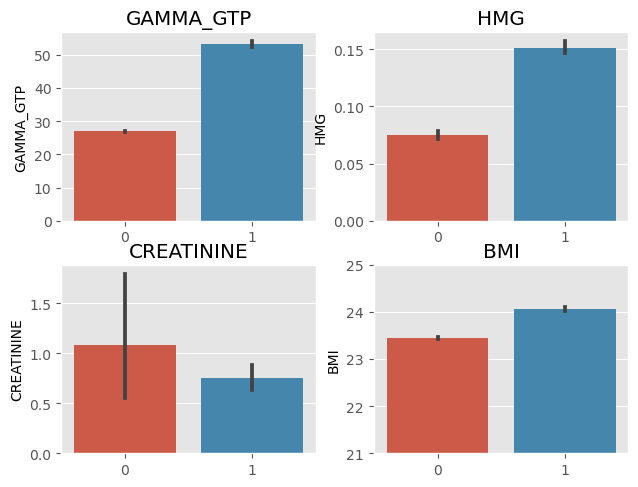

<Figure size 900x900 with 0 Axes>

In [63]:
fig, ax = plt.subplots(2,2)
plt.tight_layout()
plt.figure(figsize=(9,9))

ax = ax.flatten()

for i in range(4):
    sns.barplot(data=data, x='SMK_STAT', y=df['name'][i], ax=ax[i]).set_xlabel('')
    ax[i].set_title(df["name"][i])

ax[3].set_ylim([21,25]);

위 시각화에 대한 분석 결과는 보고서 파일을 참조 부탁드리겠습니다.

다음은 GAMMA_GTP, HMG 이렇게 두 피처를 바탕으로 산점도를 그려보겠습니다.

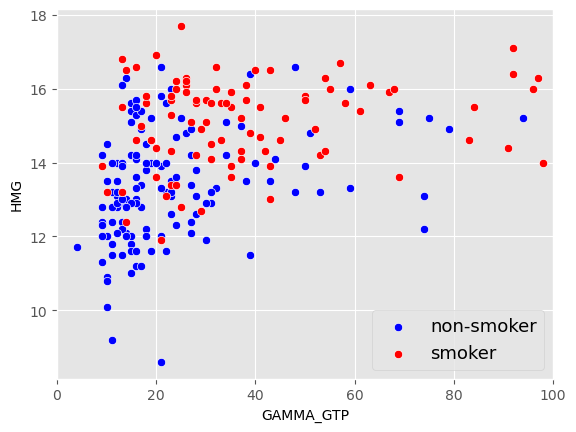

In [64]:
temp0 = raw_data.query('SMK_STAT == 1.0').sample(frac=0.002, random_state=2023)
temp1 = raw_data.query('SMK_STAT == 3.0').sample(frac=0.004, random_state=2023)

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=temp0, x='GAMMA_GTP', y='HMG', c='blue', ax=ax, label='non-smoker')
sns.scatterplot(data=temp1, x='GAMMA_GTP', y='HMG', c='red', ax=ax, label='smoker')

ax.set_xlim([0,100])
plt.legend(fontsize=13);

GAMMA_GTP, HMG의 특성 중요도를 합치면 전체의 50%를 넘게 차지하는데도 불구하고,
흡연자와 비흡연자 집단을 제대로 구분하는 것은 불가능해보입니다.

이는 이 데이터셋에서 흡연과의 강한 상관관계를 가진 피처가 존재한다기보다는,
모델로 하여금 전반적으로 여러 피처들을 골고루 학습해야 좋은 예측 결과를 내놓을 수 있다는 것을 의미합니다.

[이 이후의 결론, 느낀 점 및 아쉬운 점들은 보고서에 담겨있습니다.]